In [53]:
import pandas as pd
import numpy  as np
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
sns.set(style = 'whitegrid')

from sklearn.impute import SimpleImputer

import statsmodels.api as sm

from sklearn.linear_model import LinearRegression,Lasso,Ridge,ElasticNet

from sklearn.metrics import mean_squared_error

from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import GridSearchCV,RandomizedSearchCV

from sklearn.tree import DecisionTreeRegressor

from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor,AdaBoostRegressor,StackingRegressor

from xgboost import XGBRegressor

import scipy.stats as s

from sklearn.preprocessing import StandardScaler,MinMaxScaler

from sklearn.feature_selection import chi2,SelectKBest,RFE,f_regression,VarianceThreshold

In [54]:
plt.rcParams['figure.figsize'] = (15,8)

### Feature Engineering

In [55]:
test = pd.read_csv('test_clean.csv')
train = pd.read_csv('train_clean.csv')
xtrain = train.drop('SalePrice',axis=1)
ytrain = train.SalePrice
xtest = test.drop(['Id','SalePrice'],axis=1)
ytest = test[['Id','SalePrice']]

In [56]:
xtrain['sold_built'] = xtrain.YrSold - xtrain.YearBuilt
xtrain['sold_remod'] = xtrain.YrSold - xtrain.YearRemodAdd
xtrain['sold_garagebuit'] = xtrain.YrSold - xtrain.GarageYrBlt
xtrain = xtrain.drop(['YrSold','YearBuilt','YearRemodAdd','GarageYrBlt'],axis=1)

In [57]:
xtest['sold_built'] = xtest.YrSold - xtest.YearBuilt
xtest['sold_remod'] = xtest.YrSold - xtest.YearRemodAdd
xtest['sold_garagebuit'] = xtest.YrSold - xtest.GarageYrBlt
xtest = xtest.drop(['YrSold','YearBuilt','YearRemodAdd','GarageYrBlt'],axis=1)

In [58]:
xtest = xtest.fillna(method='bfill')

In [59]:
df_num = xtrain.select_dtypes(include=['int64','float64'])
df_cat = xtrain.select_dtypes('object')

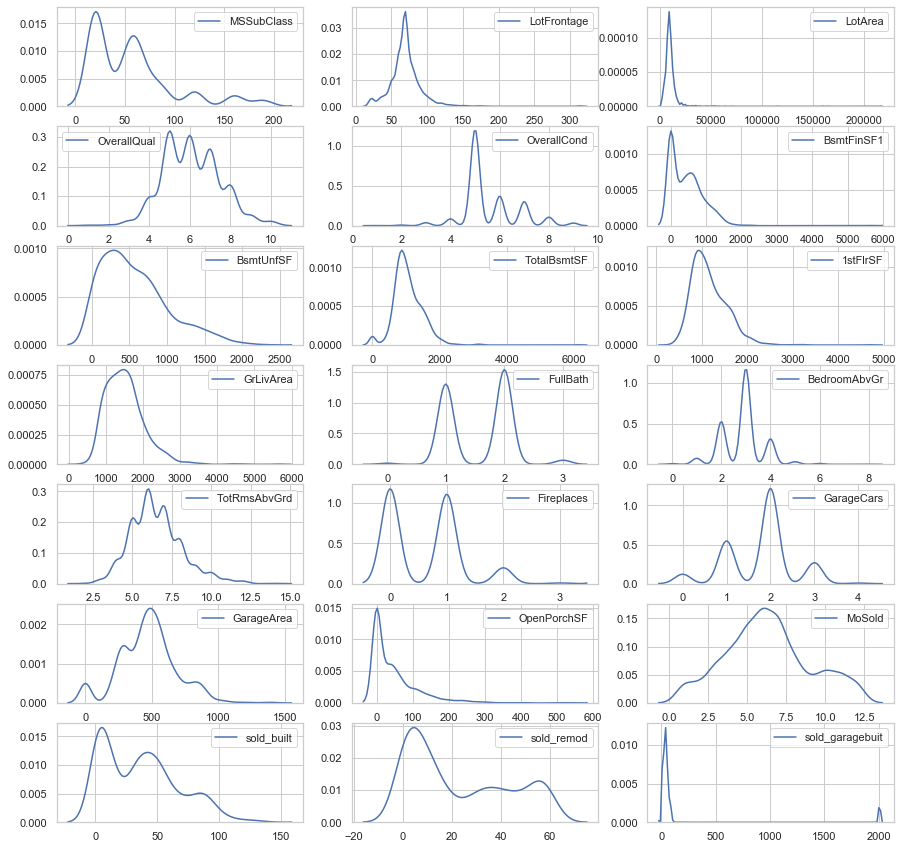

In [60]:
std_0 = []
std_not_0 = []
j=1
plt.figure(figsize=(15,15))
for i in df_num.columns:
    std_not_0.append(i)
    if xtrain[i].std() > 0.5 and xtrain[i].median() > 0.5:
        plt.subplot(7,3,j)
        sns.kdeplot(xtrain[i])
        j+=1
    else:
        std_0.append(i)

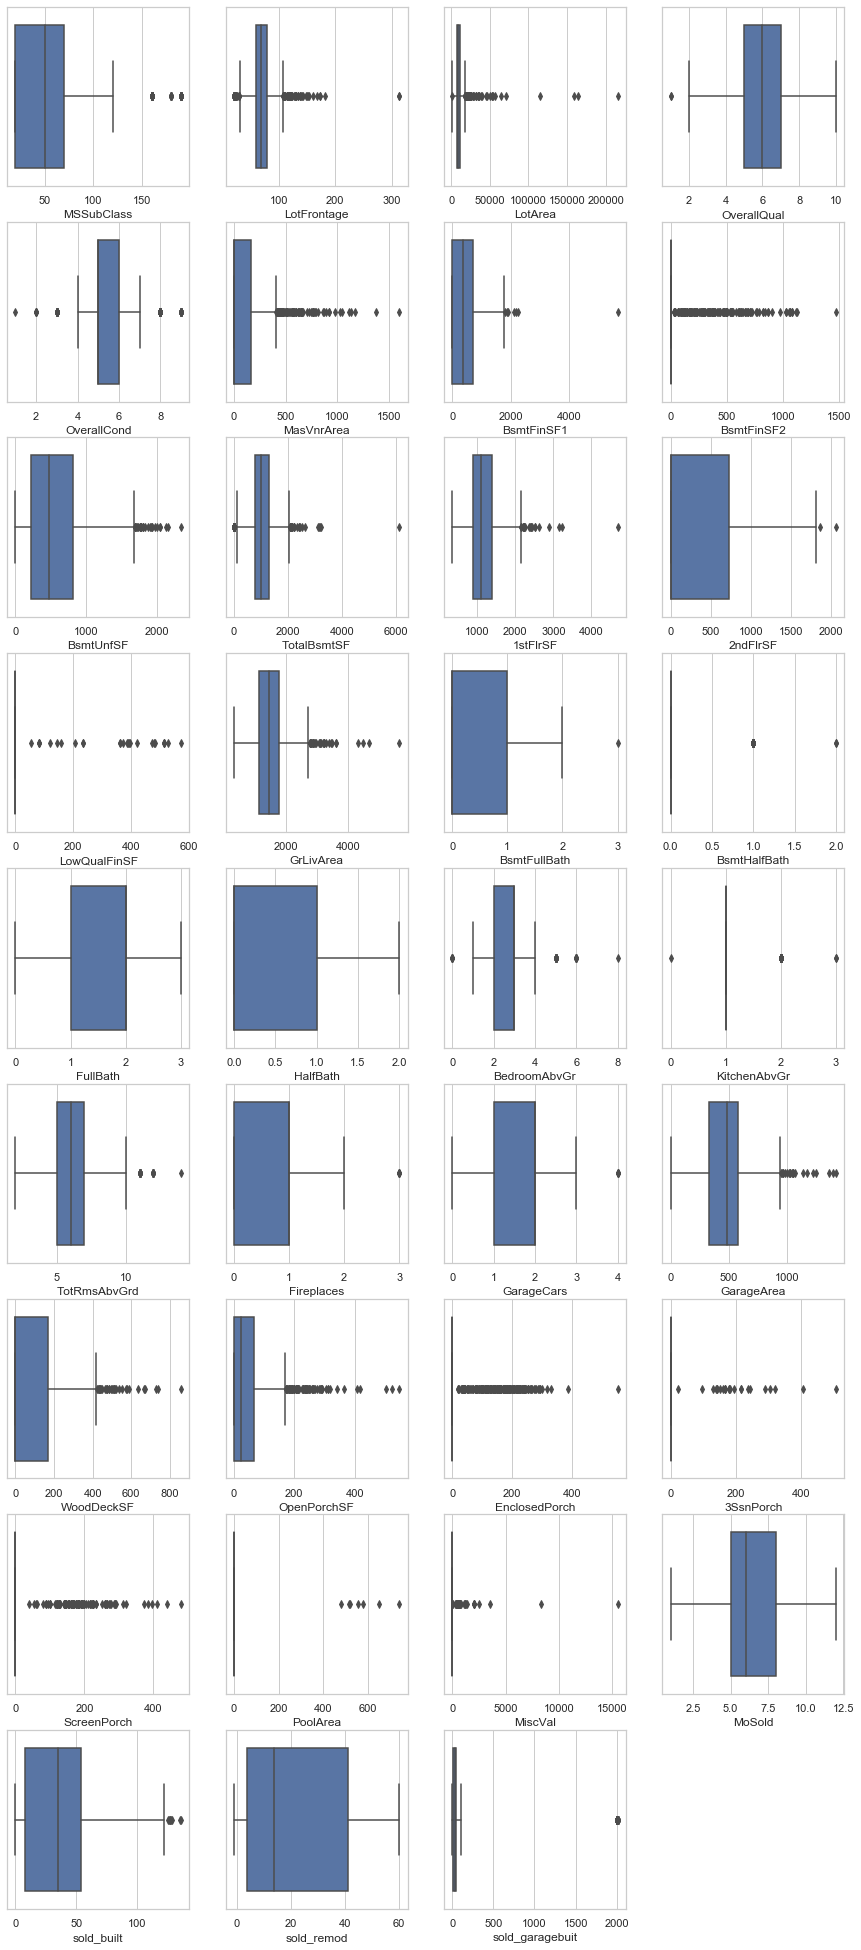

In [61]:
j=1
plt.figure(figsize=(15,35))
for i in df_num.columns:
    plt.subplot(9,4,j)
    sns.boxplot(xtrain[i])
    j+=1

In [62]:
def zeros_check(col,check_val):
    df = train.copy()
    t = pd.Series(np.where(xtrain[col]==check_val,'Zero','NonZero'))
    df['grouped'] = t
    t.value_counts().plot(kind='bar')
    plt.title('Value count plot for {} column'.format(col)) 
    plt.show()
    df.groupby('grouped')['SalePrice'].mean().sort_values().plot(kind='bar')
    plt.show()
    sns.scatterplot(y=col,x='SalePrice',data=df,hue=df['grouped'])
    return

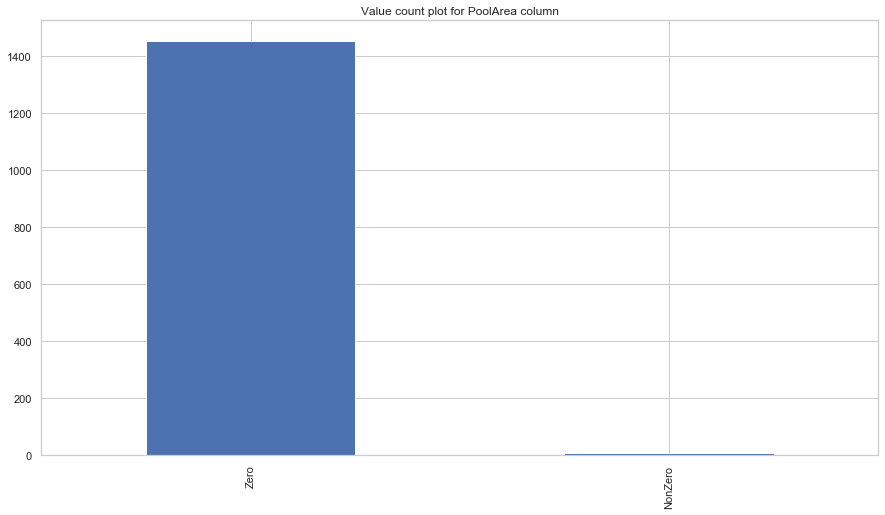

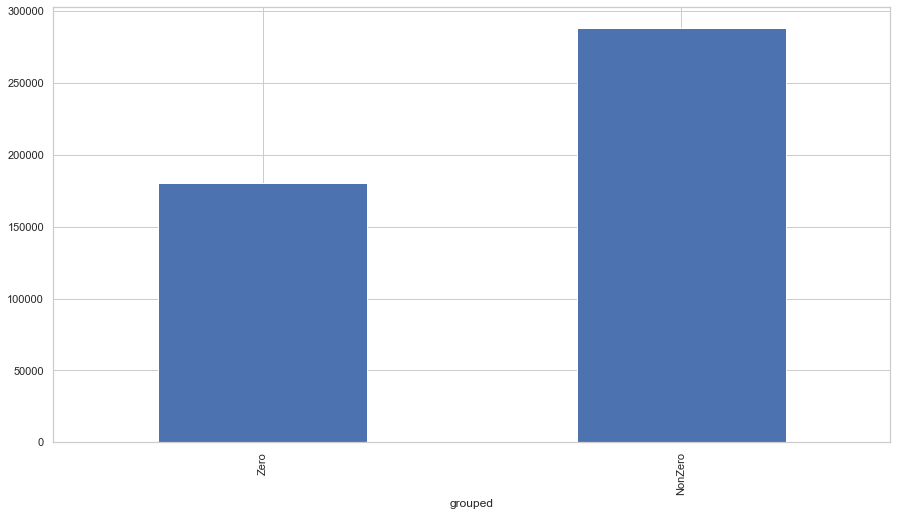

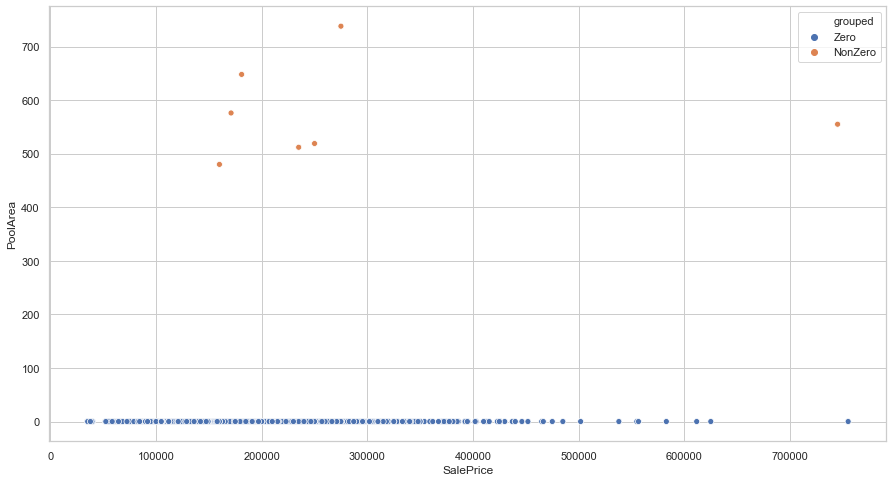

In [63]:
zeros_check('PoolArea',0)

In [64]:
# As most of the houses dosen't have pool area we can drop the column.

In [65]:
xtrain.drop('PoolArea',axis=1,inplace=True) 
xtest.drop('PoolArea',axis=1,inplace=True)

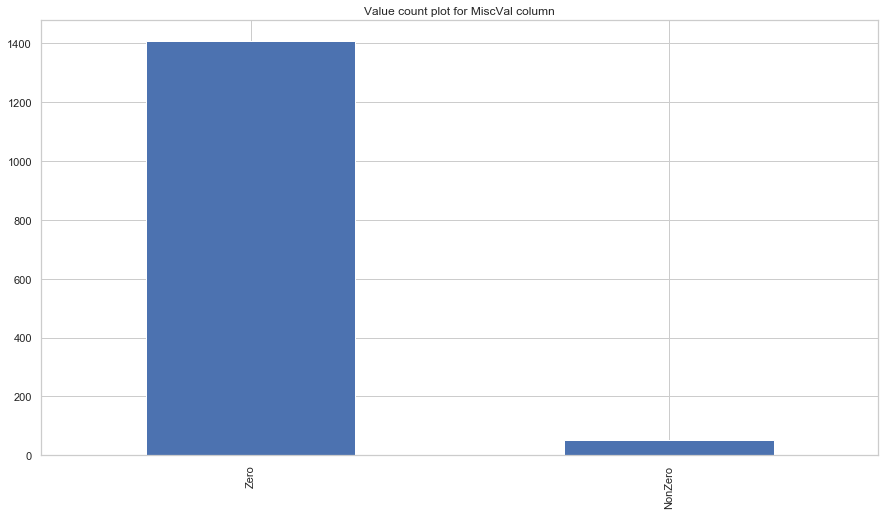

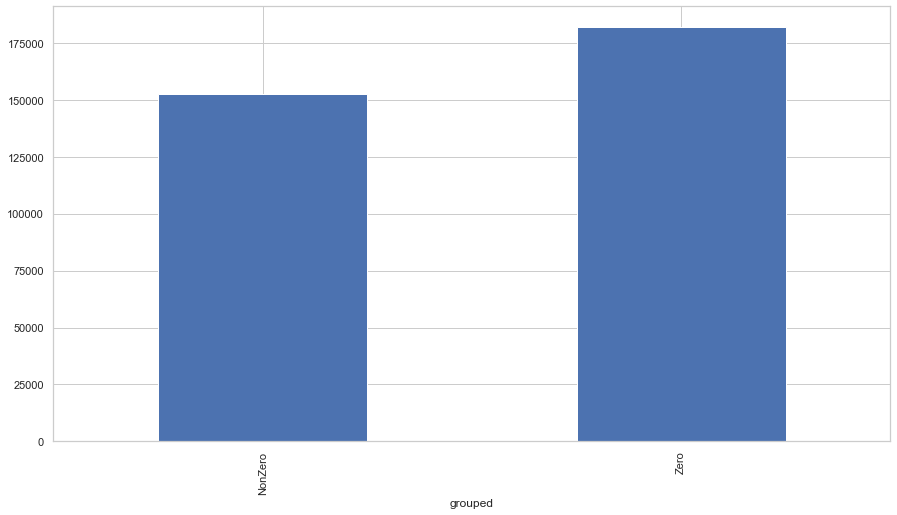

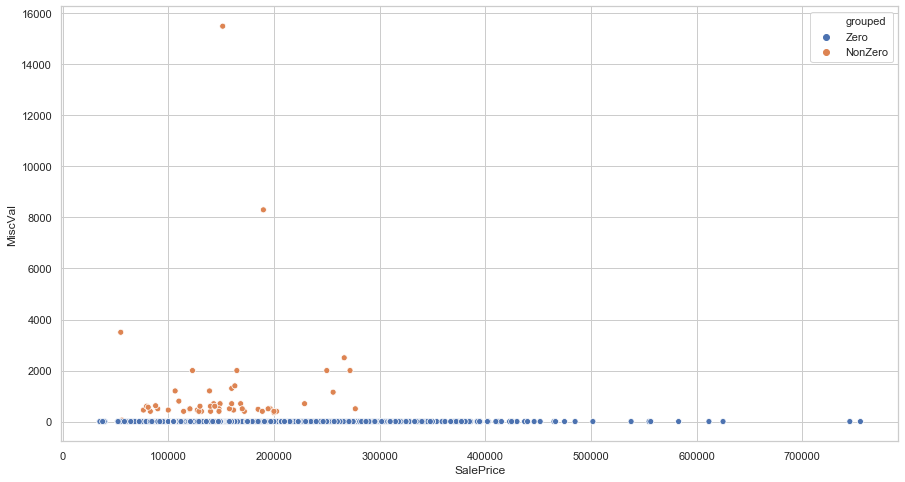

In [66]:
zeros_check('MiscVal',0)

In [67]:
xtrain.drop('MiscVal',axis=1,inplace=True) 
xtest.drop('MiscVal',axis=1,inplace=True)

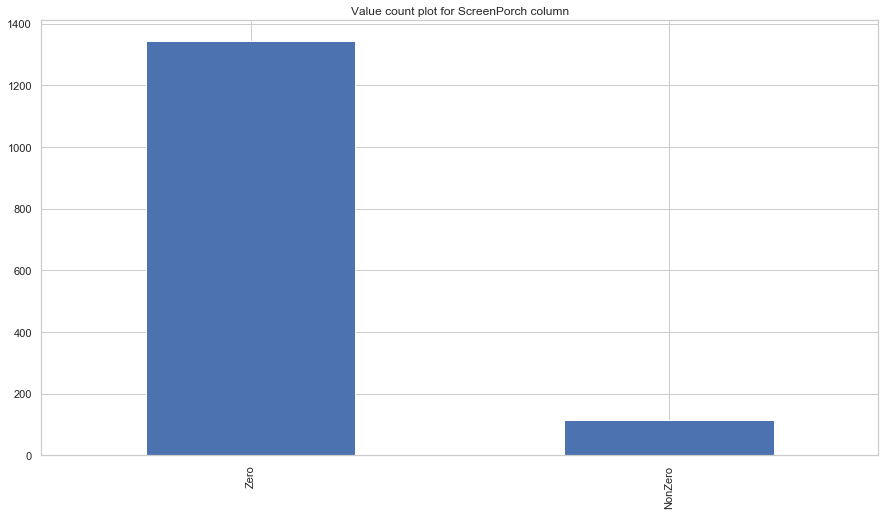

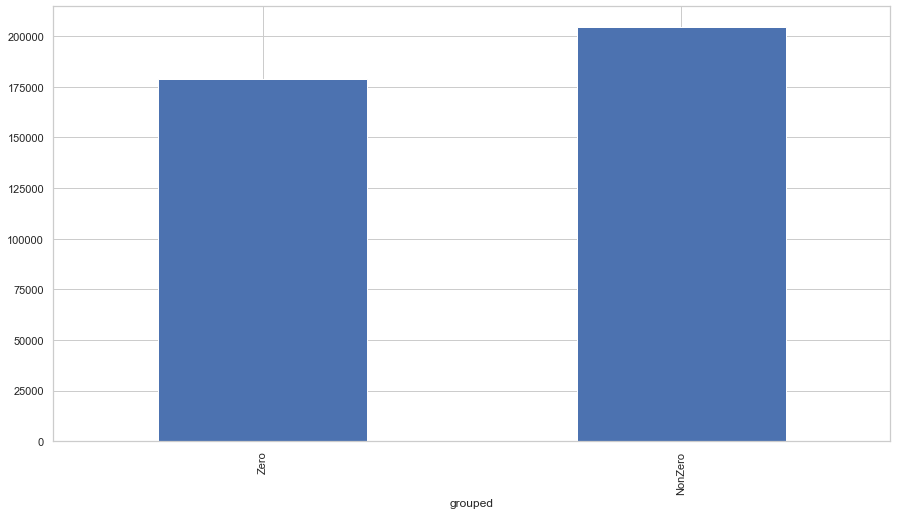

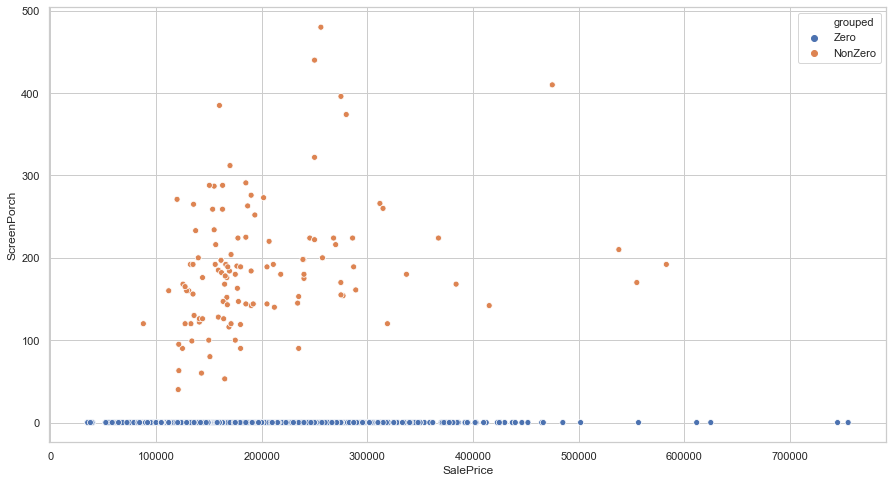

In [68]:
zeros_check('ScreenPorch',0)

In [69]:
#xtrain.drop('ScreenPorch',axis=1,inplace=True) 
#xtest.drop('ScreenPorch',axis=1,inplace=True)

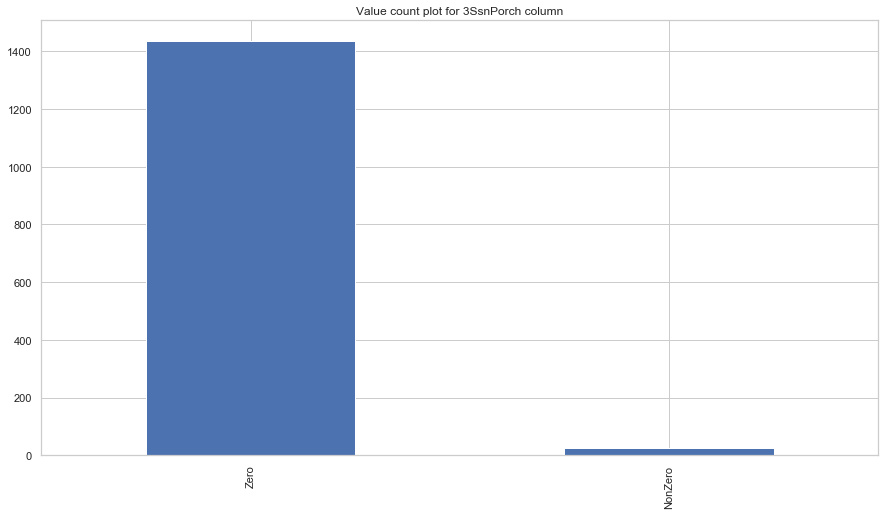

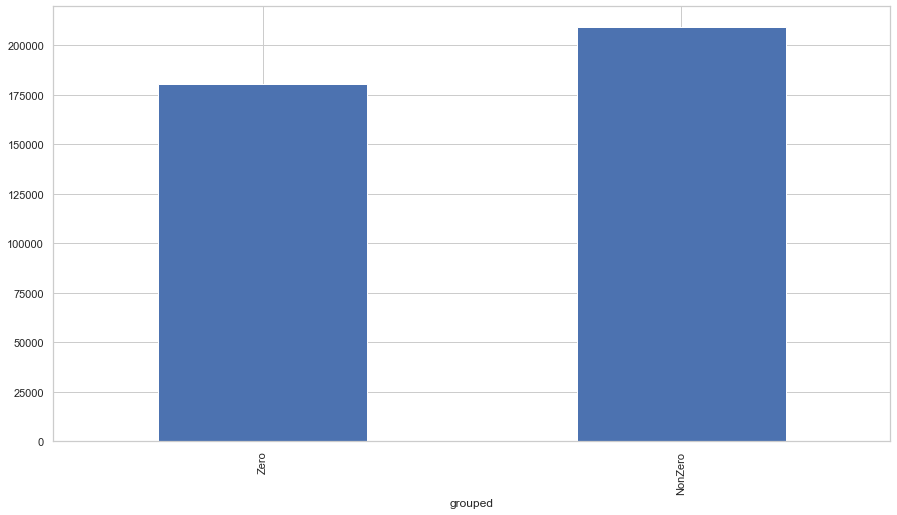

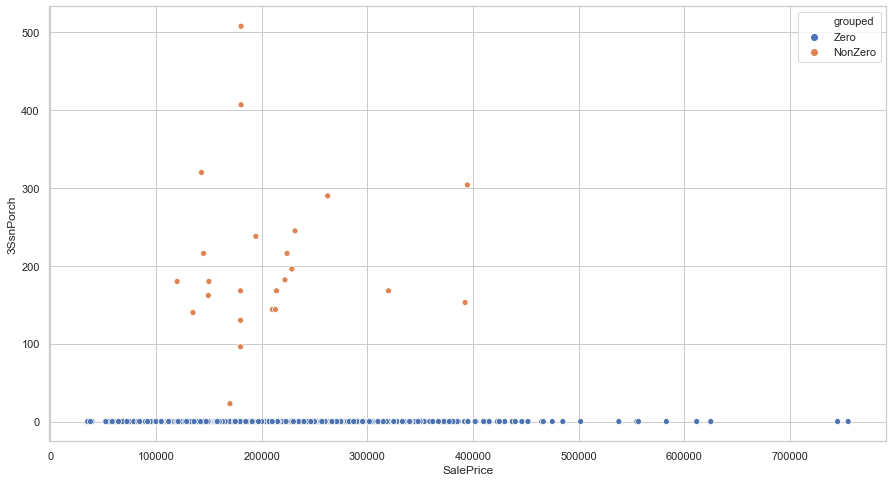

In [70]:
zeros_check('3SsnPorch',0)

In [71]:
xtrain.drop('3SsnPorch',axis=1,inplace=True) 
xtest.drop('3SsnPorch',axis=1,inplace=True)

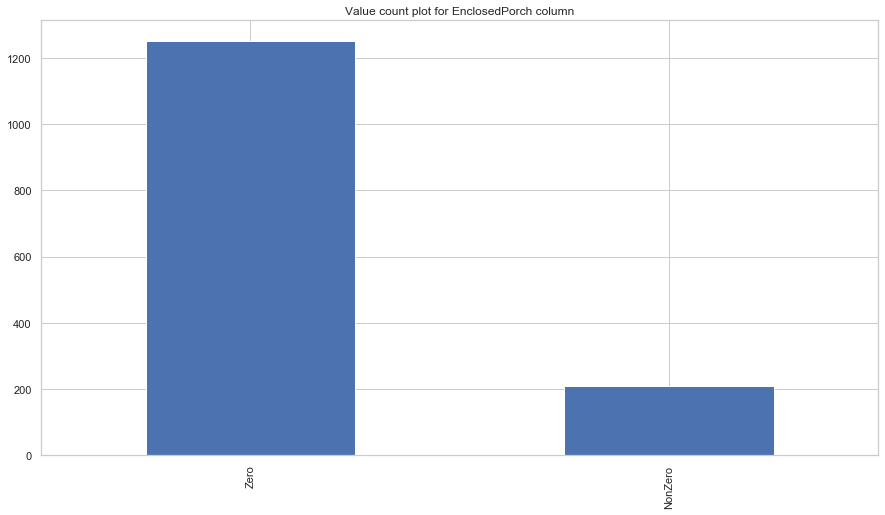

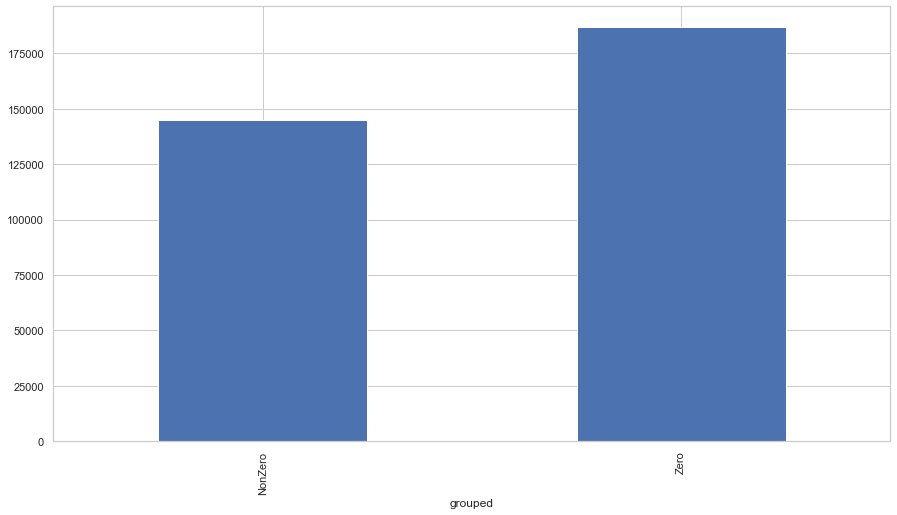

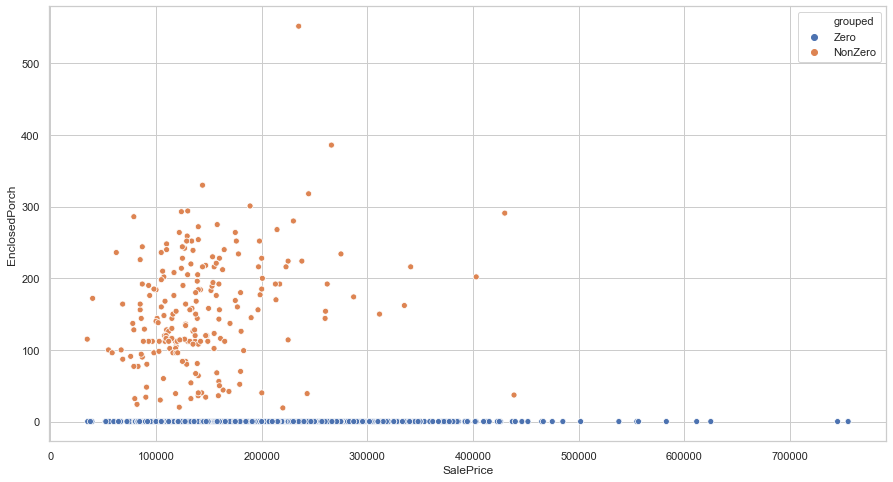

In [72]:
zeros_check('EnclosedPorch',0)

In [73]:
#xtrain.drop('EnclosedPorch',axis=1,inplace=True)

#xtest.drop('EnclosedPorch',axis=1,inplace=True)

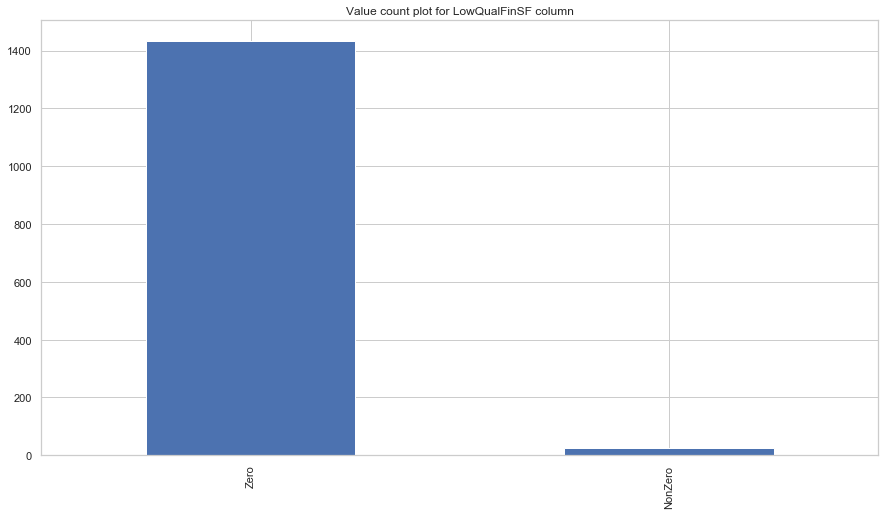

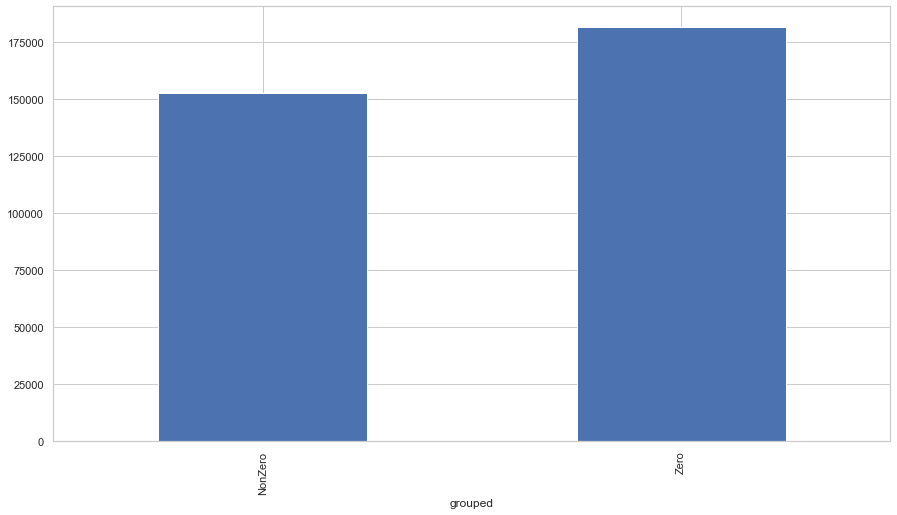

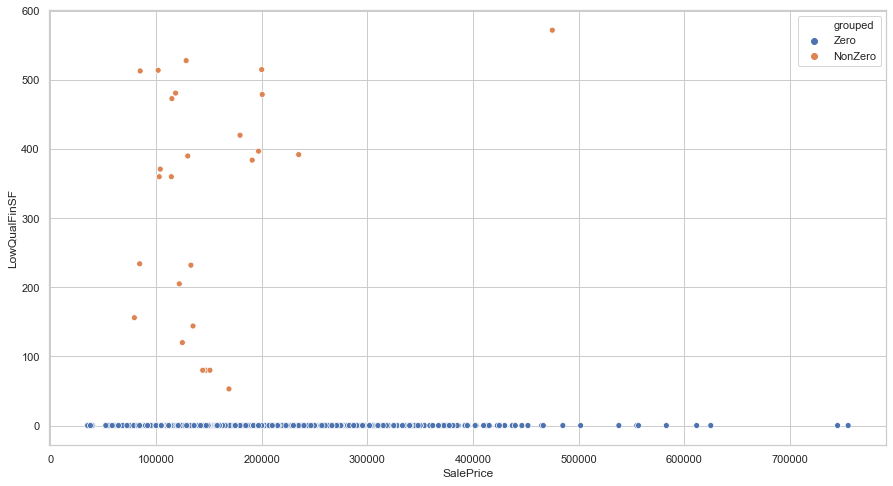

In [74]:
zeros_check('LowQualFinSF',0)

In [75]:
xtrain.drop('LowQualFinSF',axis=1,inplace=True) 
xtest.drop('LowQualFinSF',axis=1,inplace=True)

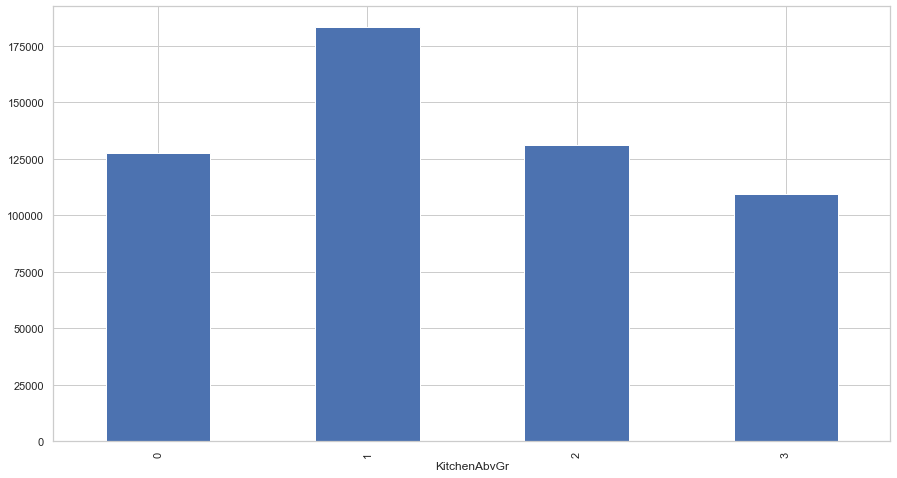

In [76]:
train.groupby('KitchenAbvGr')['SalePrice'].mean().plot(kind='bar')

In [77]:
#xtrain.drop('KitchenAbvGr',axis=1,inplace=True)
#xtest.drop('KitchenAbvGr',axis=1,inplace=True)

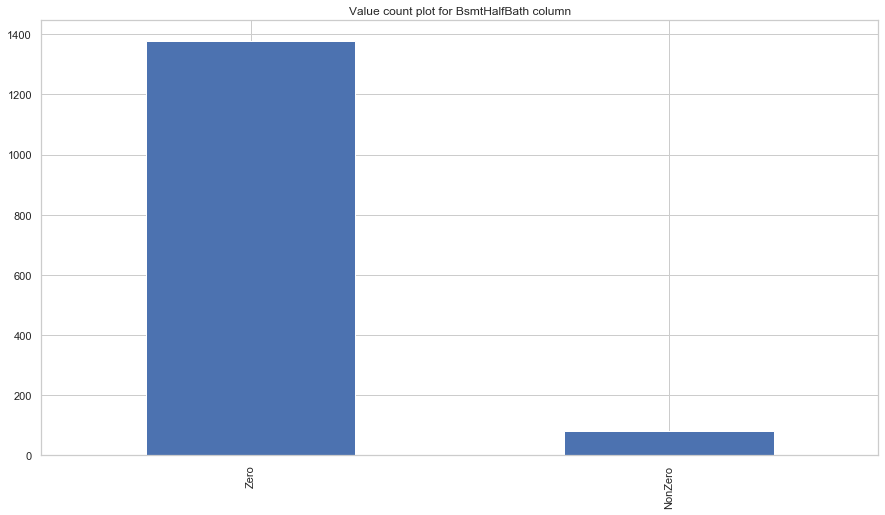

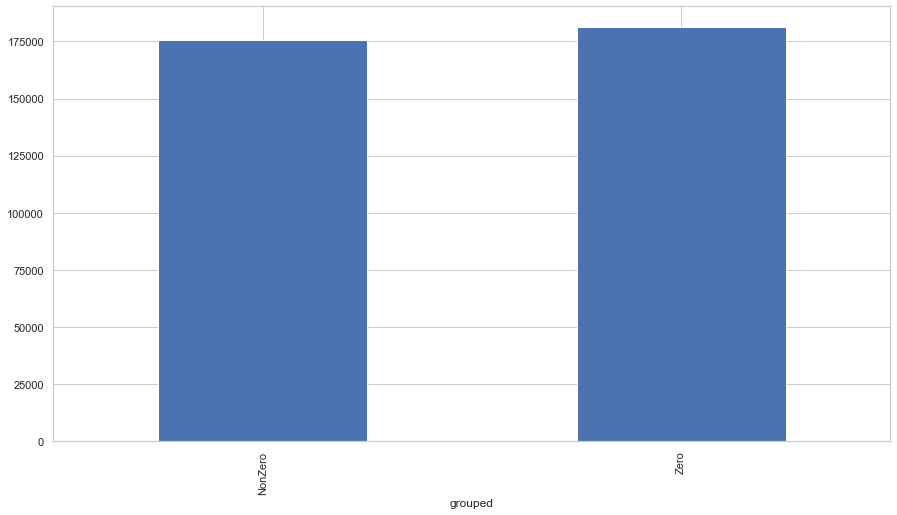

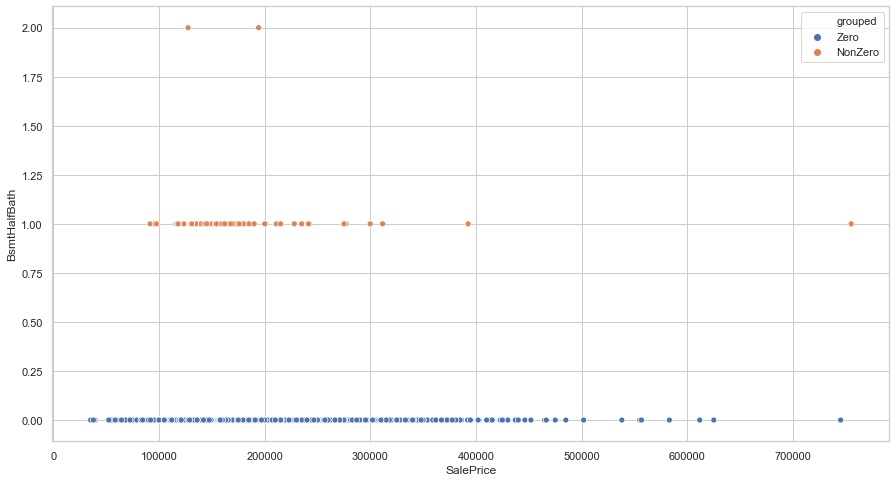

In [78]:
zeros_check('BsmtHalfBath',0)

In [79]:
xtrain.drop('BsmtHalfBath',axis=1,inplace=True)
xtest.drop('BsmtHalfBath',axis=1,inplace=True)

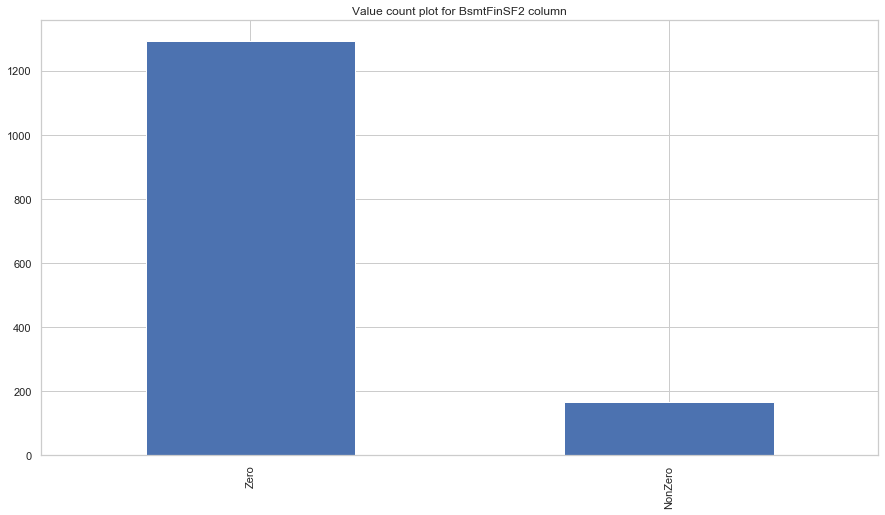

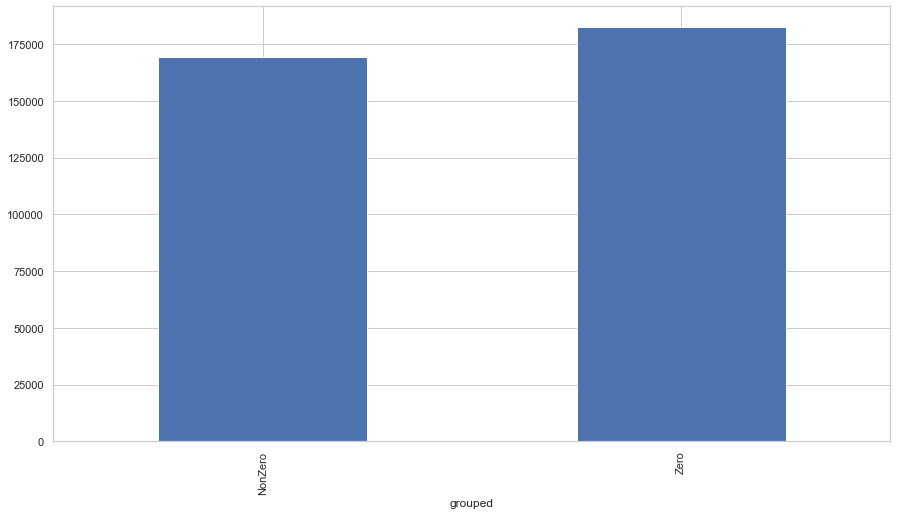

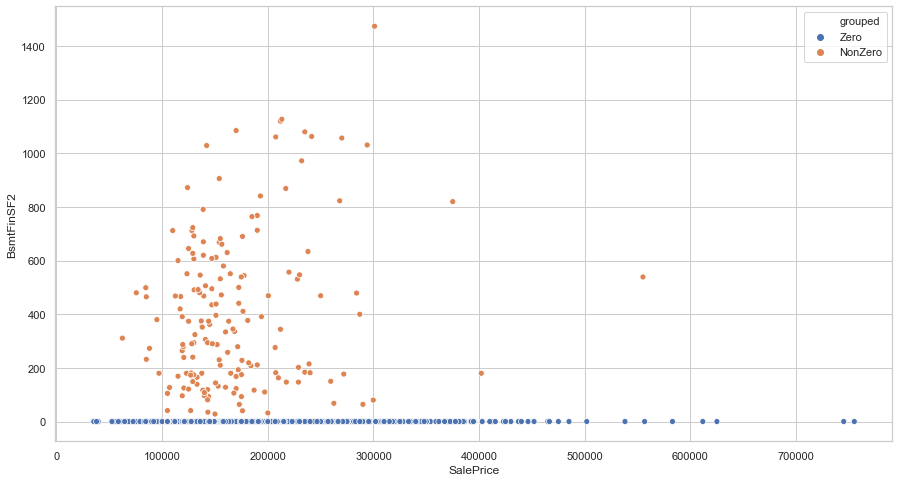

In [80]:
zeros_check('BsmtFinSF2',0)

In [81]:
#xtrain.drop('BsmtFinSF2',axis=1,inplace=True)
#xtest.drop('BsmtFinSF2',axis=1,inplace=True)

### Outlier Treatment

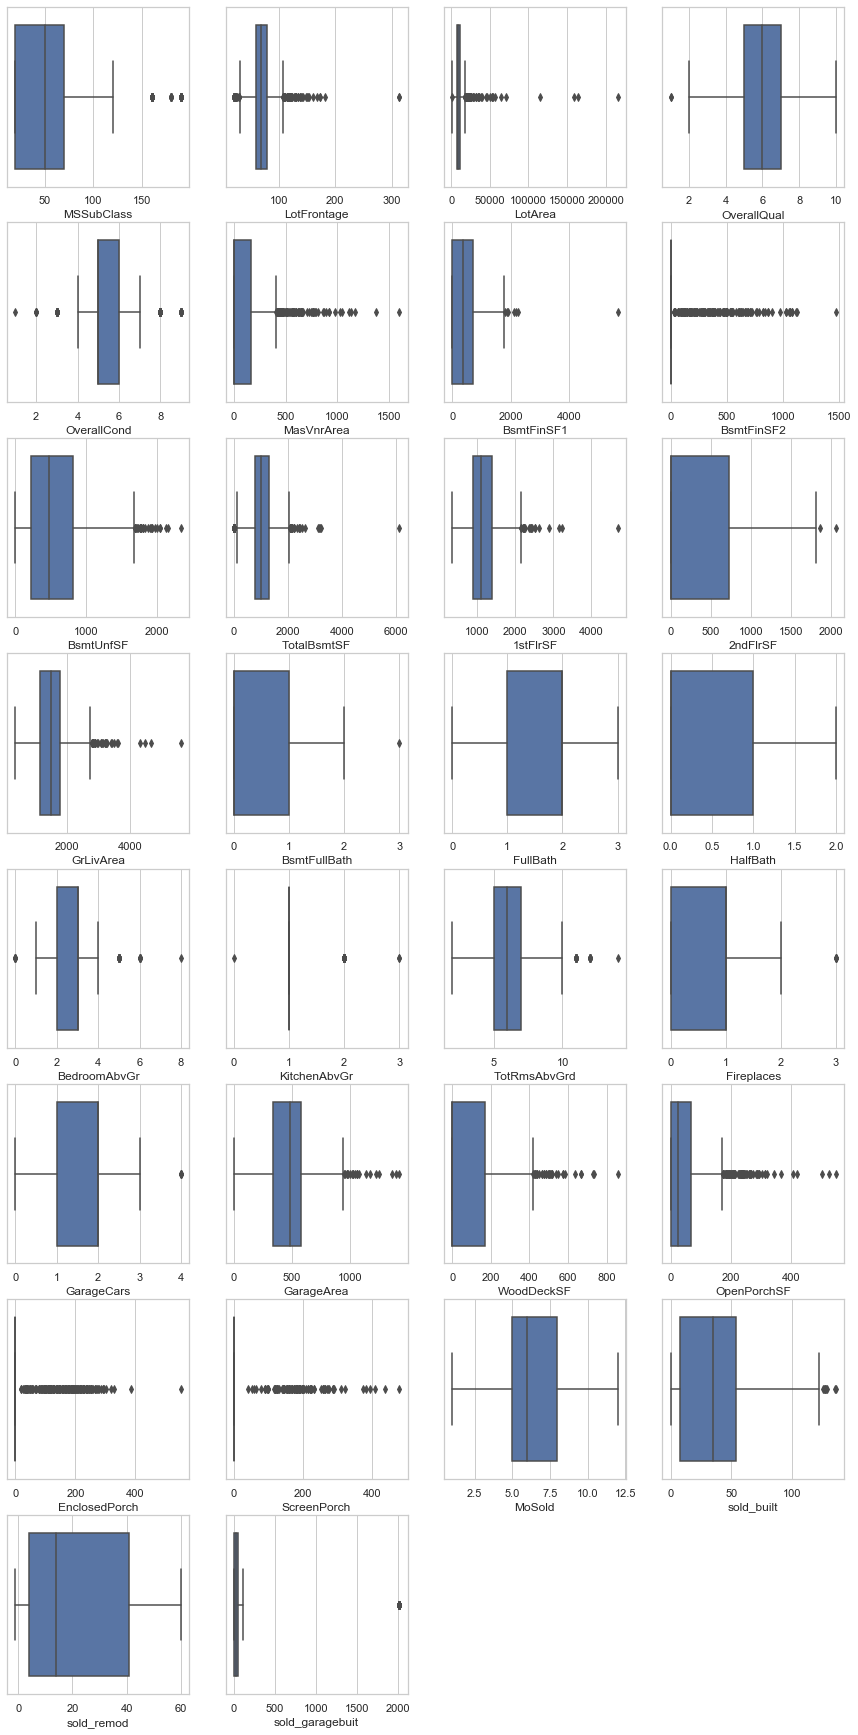

In [82]:
j=1
plt.figure(figsize=(15,35))
for i in xtrain.select_dtypes(include=['int64','float64']).columns:
    plt.subplot(9,4,j)
    sns.boxplot(xtrain[i])
    j+=1

In [83]:
for i in xtrain.select_dtypes(include=['int64','float64']).columns:
    iqr = xtrain[i].quantile(0.75) - xtrain[i].quantile(0.25)
    ul = xtrain[i].quantile(0.75) + 1.5*iqr
    ll = xtrain[i].quantile(0.25) - 1.5*iqr
    t = []
    for j in xtrain[i]:
        if j > ul or j < ll:
            t.append(xtrain[i].median())
        else:
            t.append(j)
    xtrain[i] = t

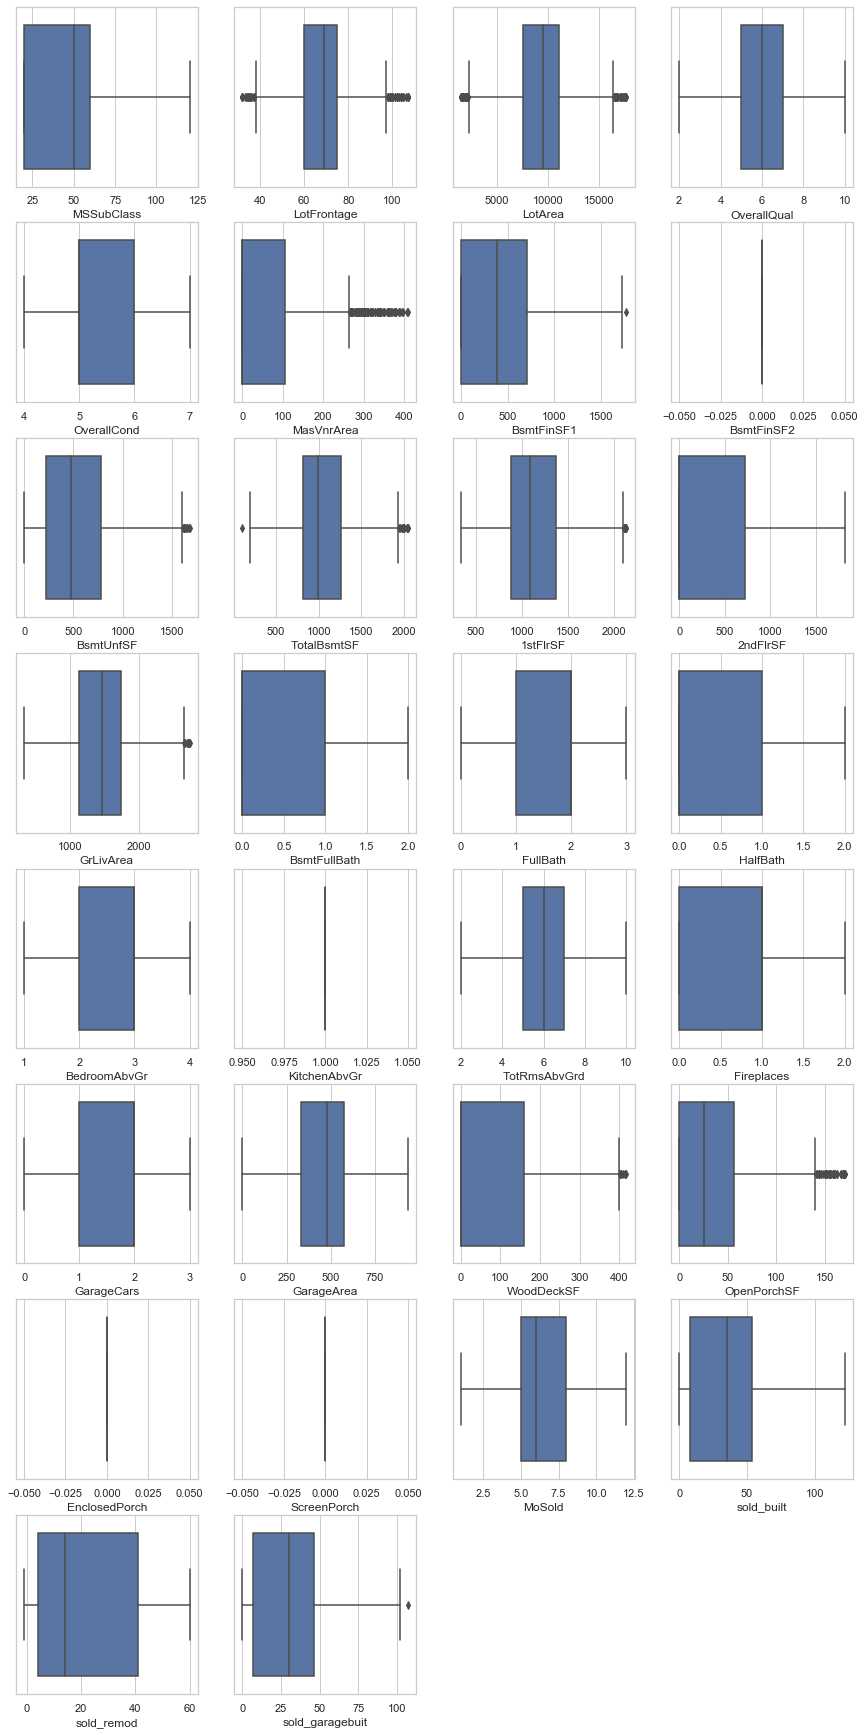

In [84]:
j=1
plt.figure(figsize=(15,35))
for i in xtrain.select_dtypes(include=['int64','float64']).columns:
    plt.subplot(9,4,j)
    sns.boxplot(xtrain[i])
    j+=1

In [85]:
skew = [xtrain[i].skew() for i in xtrain.select_dtypes(include=['int64','float64']).columns]
skew = pd.DataFrame({'Column': xtrain.select_dtypes(include=['int64','float64']).columns,
                     'Skewness': skew,'abs_skew':[abs(i) for i in skew]}).sort_values('abs_skew',ascending=False)
skew

,Column,Skewness,abs_skew
5,MasVnrArea,1.546117,1.546117
23,OpenPorchSF,1.223148,1.223148
22,WoodDeckSF,1.027287,1.027287
4,OverallCond,0.938327,0.938327
0,MSSubClass,0.838396,0.838396
11,2ndFlrSF,0.781915,0.781915
8,BsmtUnfSF,0.736641,0.736641
6,BsmtFinSF1,0.688010,0.688010
15,HalfBath,0.677972,0.677972
29,sold_garagebuit,0.654195,0.654195


In [86]:
xtrain.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,...,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,ScreenPorch,MoSold,sold_built,sold_remod,sold_garagebuit
count,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.0,1459.000000,1459.000000,...,1459.000000,1459.000000,1459.000000,1459.000000,1459.0,1459.0,1459.000000,1459.000000,1459.000000,1459.000000
mean,48.361892,68.790953,9276.406443,6.106923,5.414668,61.886223,433.598355,0.0,539.919808,1057.366690,...,1.760110,464.123372,82.589445,34.980123,0.0,0.0,6.322824,36.055517,22.965045,29.363948
std,28.157709,13.850447,3128.251270,1.370200,0.776068,103.978713,423.107753,0.0,401.279951,340.490444,...,0.736114,199.319180,106.556801,43.106135,0.0,0.0,2.704331,29.454092,20.639721,24.027986
min,20.000000,32.000000,1477.000000,2.000000,4.000000,0.000000,0.000000,0.0,0.000000,105.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1.000000,0.000000,-1.000000,0.000000
25%,20.000000,60.000000,7559.000000,5.000000,5.000000,0.000000,0.000000,0.0,223.000000,816.000000,...,1.000000,333.000000,0.000000,0.000000,0.0,0.0,5.000000,8.000000,4.000000,7.000000
50%,50.000000,69.000000,9477.000000,6.000000,5.000000,0.000000,384.000000,0.0,479.000000,992.000000,...,2.000000,480.000000,0.000000,25.000000,0.0,0.0,6.000000,35.000000,14.000000,30.000000
75%,60.000000,75.000000,11111.500000,7.000000,6.000000,106.000000,703.000000,0.0,779.500000,1265.000000,...,2.000000,576.000000,160.000000,56.000000,0.0,0.0,8.000000,54.000000,41.000000,46.000000
max,120.000000,107.000000,17671.000000,10.000000,7.000000,410.000000,1767.000000,0.0,1680.000000,2046.000000,...,3.000000,936.000000,418.000000,170.000000,0.0,0.0,12.000000,122.000000,60.000000,107.000000


In [87]:
xtrain['MasVnrArea'] = np.sqrt(xtrain['MasVnrArea'])
xtrain['OpenPorchSF'] = np.sqrt(xtrain['OpenPorchSF'])

xtrain['WoodDeckSF'] = np.sqrt(xtrain['WoodDeckSF'])

xtrain['MSSubClass'] = np.sqrt(xtrain['MSSubClass'])

xtrain['sold_garagebuit'] = np.sqrt(xtrain['sold_garagebuit'])

xtrain['2ndFlrSF'] = np.sqrt(xtrain['2ndFlrSF'])

xtrain['BsmtUnfSF'] = np.sqrt(xtrain['BsmtUnfSF'])

xtrain['BsmtFinSF1'] = np.sqrt(xtrain['BsmtFinSF1'])

xtrain['HalfBath'] = np.sqrt(xtrain['HalfBath'])

xtrain['1stFlrSF'] =  np.sqrt(xtrain['1stFlrSF'])

xtrain['GrLivArea'] = np.sqrt(xtrain['GrLivArea'])

xtrain['sold_built'] = np.sqrt(xtrain['sold_built'])

xtrain['Fireplaces'] = np.sqrt(xtrain['Fireplaces'])

xtrain['OverallCond'] =  np.sqrt(xtrain['OverallCond'])

xtrain['BsmtFullBath'] =np.sqrt(xtrain['BsmtFullBath'])

In [88]:
xtrain.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,...,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,ScreenPorch,MoSold,sold_built,sold_remod,sold_garagebuit
count,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.0,1459.000000,1459.000000,...,1459.000000,1459.000000,1459.000000,1459.000000,1459.0,1459.0,1459.000000,1459.000000,1459.000000,1459.000000
mean,6.665192,68.790953,9276.406443,6.106923,2.321271,4.374428,16.323906,0.0,21.004617,1057.366690,...,1.760110,464.123372,5.963386,4.187645,0.0,0.0,6.322824,5.287008,22.965045,4.781552
std,1.984895,13.850447,3128.251270,1.370200,0.162437,6.540636,12.932250,0.0,9.939496,340.490444,...,0.736114,199.319180,6.860009,4.178004,0.0,0.0,2.704331,2.847563,20.639721,2.550523
min,4.472136,32.000000,1477.000000,2.000000,2.000000,0.000000,0.000000,0.0,0.000000,105.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1.000000,0.000000,-1.000000,0.000000
25%,4.472136,60.000000,7559.000000,5.000000,2.236068,0.000000,0.000000,0.0,14.933185,816.000000,...,1.000000,333.000000,0.000000,0.000000,0.0,0.0,5.000000,2.828427,4.000000,2.645751
50%,7.071068,69.000000,9477.000000,6.000000,2.236068,0.000000,19.595918,0.0,21.886069,992.000000,...,2.000000,480.000000,0.000000,5.000000,0.0,0.0,6.000000,5.916080,14.000000,5.477226
75%,7.745967,75.000000,11111.500000,7.000000,2.449490,10.295630,26.514140,0.0,27.919526,1265.000000,...,2.000000,576.000000,12.649111,7.483315,0.0,0.0,8.000000,7.348469,41.000000,6.782330
max,10.954451,107.000000,17671.000000,10.000000,2.645751,20.248457,42.035699,0.0,40.987803,2046.000000,...,3.000000,936.000000,20.445048,13.038405,0.0,0.0,12.000000,11.045361,60.000000,10.344080


In [89]:
xtest.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,OpenPorchSF,EnclosedPorch,ScreenPorch,Fence,MoSold,SaleType,SaleCondition,sold_built,sold_remod,sold_garagebuit
0,20,RH,80.0,11622,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,120,MnPrv,6,WD,Normal,49,49,49.0
1,20,RL,81.0,14267,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,36,0,0,NoFence,6,WD,Normal,52,52,52.0
2,60,RL,74.0,13830,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,34,0,0,MnPrv,3,WD,Normal,13,12,13.0
3,60,RL,78.0,9978,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,36,0,0,NoFence,6,WD,Normal,12,12,12.0
4,120,RL,43.0,5005,Pave,IR1,HLS,AllPub,Inside,Gtl,...,82,0,144,NoFence,1,WD,Normal,18,18,18.0


In [90]:
for i in xtest.select_dtypes(include=['int64','float64']).columns:
    iqr = xtest[i].quantile(0.75) - xtest[i].quantile(0.25)
    ul = xtest[i].quantile(0.75) + 1.5*iqr
    ll = xtest[i].quantile(0.25) - 1.5*iqr
    t = []
    for j in xtest[i]:
        if j > ul:
            t.append(ul)
        elif j < ll:
            t.append(ll)
        else:
            t.append(j)
    xtest[i] = t

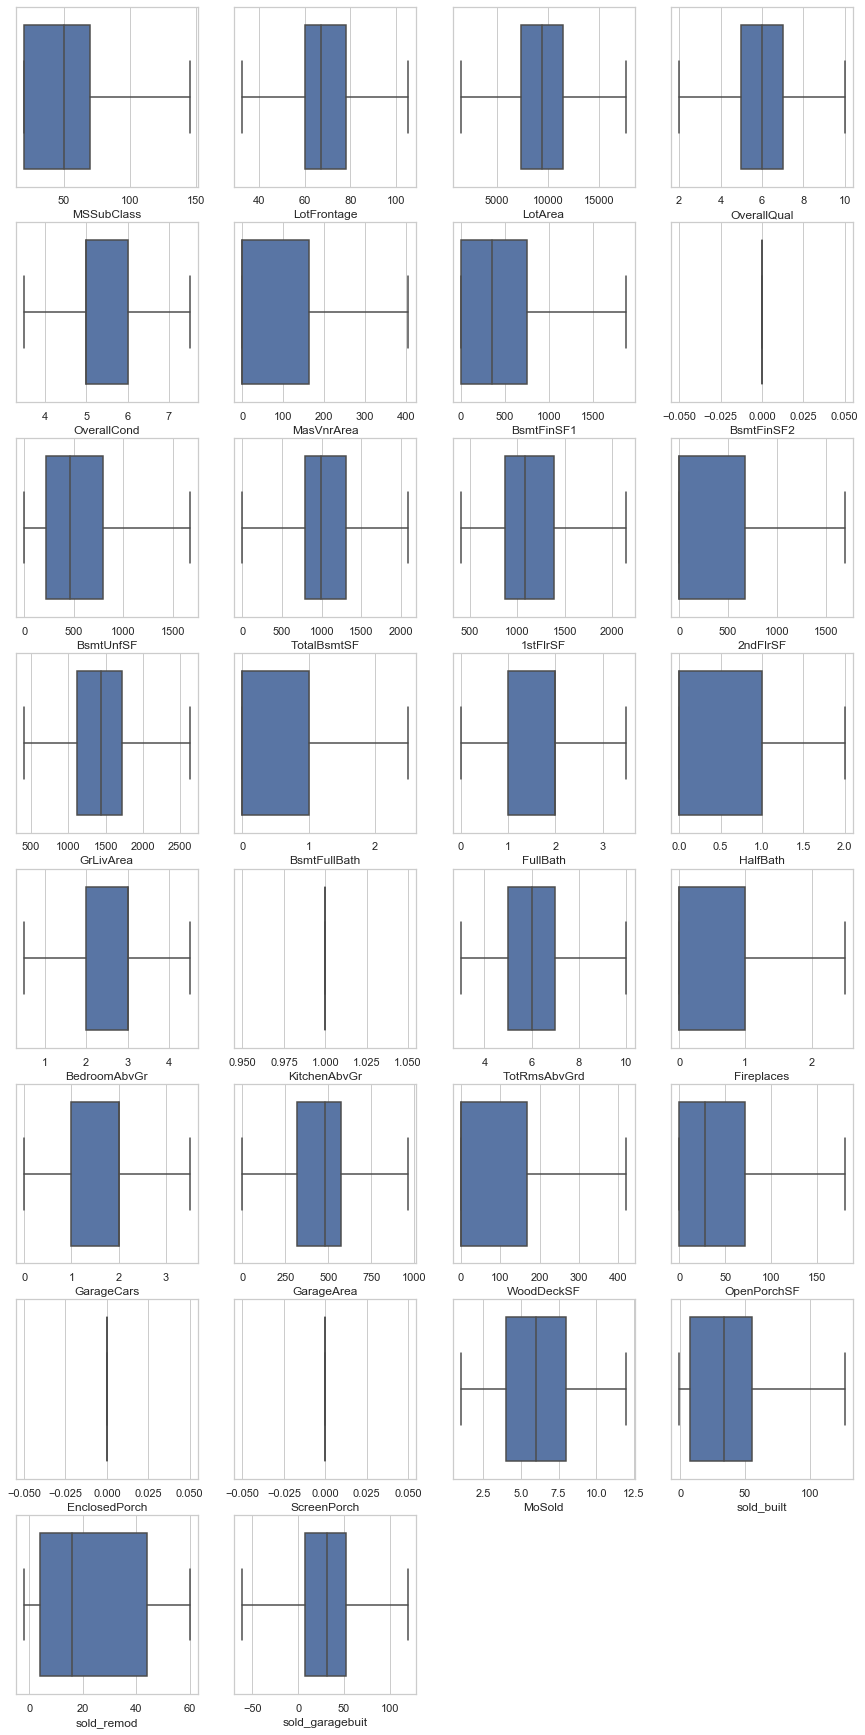

In [91]:
j=1
plt.figure(figsize=(15,35))
for i in xtest.select_dtypes(include=['int64','float64']).columns:
    plt.subplot(9,4,j)
    sns.boxplot(xtest[i])
    j+=1

In [92]:
skew_test = [xtest[i].skew() for i in xtest.select_dtypes(include=['int64','float64']).columns]
skew_test = pd.DataFrame({'Column': xtest.select_dtypes(include=['int64','float64']).columns,
                     'Skewness': skew_test,'abs_skew':[abs(i) for i in skew_test]}).sort_values('abs_skew',ascending=False)
skew_test

,Column,Skewness,abs_skew
5,MasVnrArea,1.328953,1.328953
23,OpenPorchSF,1.188823,1.188823
22,WoodDeckSF,1.104194,1.104194
29,sold_garagebuit,1.007202,1.007202
0,MSSubClass,0.973321,0.973321
11,2ndFlrSF,0.893148,0.893148
6,BsmtFinSF1,0.844772,0.844772
8,BsmtUnfSF,0.841434,0.841434
15,HalfBath,0.714728,0.714728
19,Fireplaces,0.677482,0.677482


In [93]:
xtest['MasVnrArea'] = np.sqrt(xtest['MasVnrArea'])
xtest['OpenPorchSF'] = np.sqrt(xtest['OpenPorchSF'])

xtest['WoodDeckSF'] = np.sqrt(xtest['WoodDeckSF'])

xtest['MSSubClass'] = np.sqrt(xtest['MSSubClass'])

xtest['sold_garagebuit'] = np.sqrt(xtest['sold_garagebuit'])

xtest['2ndFlrSF'] = np.sqrt(xtest['2ndFlrSF'])

xtest['BsmtUnfSF'] = np.sqrt(xtest['BsmtUnfSF'])

xtest['BsmtFinSF1'] = np.sqrt(xtest['BsmtFinSF1'])

xtest['HalfBath'] = np.sqrt(xtest['HalfBath'])

xtest['1stFlrSF'] =  np.sqrt(xtest['1stFlrSF'])

xtest['GrLivArea'] = np.sqrt(xtest['GrLivArea'])

xtest['sold_built'] = np.sqrt(xtest['sold_built'])

xtest['Fireplaces'] = np.sqrt(xtest['Fireplaces'])

xtest['OverallCond'] =  np.sqrt(xtest['OverallCond'])

xtest['BsmtFullBath'] =np.sqrt(xtest['BsmtFullBath'])

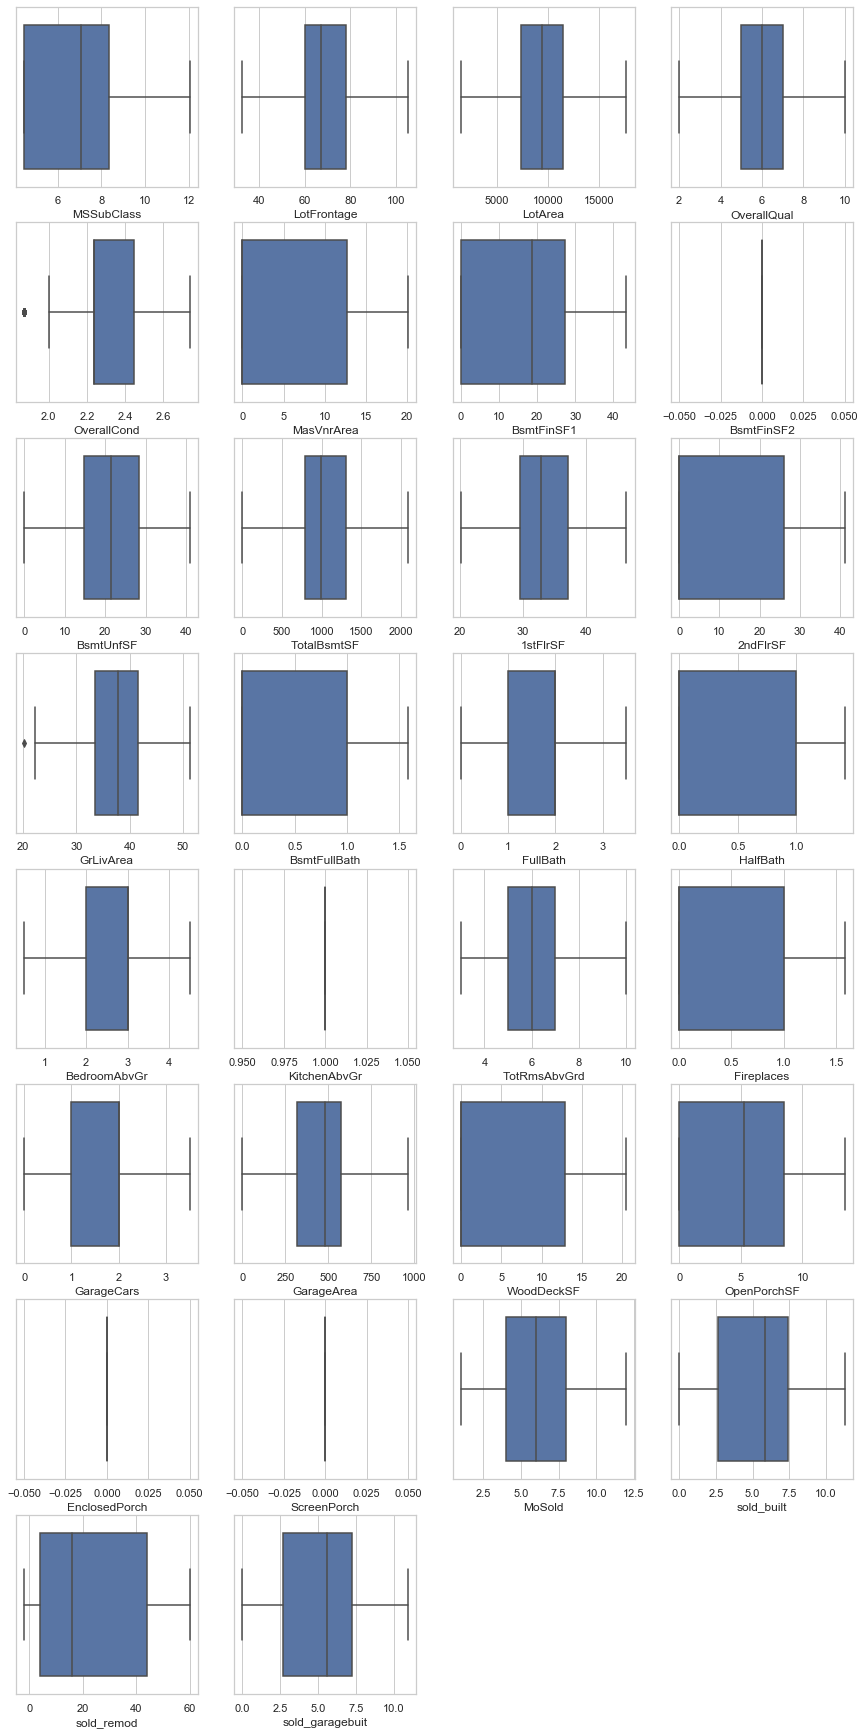

In [94]:
j=1
plt.figure(figsize=(15,35))
for i in xtest.select_dtypes(include=['int64','float64']).columns:
    plt.subplot(9,4,j)
    sns.boxplot(xtest[i])
    j+=1

### Scaling

In [95]:
test_cat = xtest.select_dtypes('object')
train_cat = xtrain.select_dtypes('object')
df = pd.concat((train_cat,test_cat),axis=0)
df = pd.get_dummies(df,drop_first=True)

In [96]:
train_cat = df.iloc[np.arange(0,1459),:]
test_cat = df.iloc[np.arange(1459,len(df)),:]

In [97]:
df_num = xtrain.select_dtypes(include=['int64','float64'])
mm= MinMaxScaler()
df_num_scaled = pd.DataFrame(mm.fit_transform(df_num),columns = df_num.columns)

In [98]:
xtrain1 = pd.concat((df_num_scaled,train_cat),axis=1)

In [99]:
df_num_test = xtest.select_dtypes(include=['int64','float64'])
df_num_scaled = pd.DataFrame(mm.transform(df_num_test),columns = df_num_test.columns)
df_num_scaled = df_num_scaled.fillna(method='bfill')

In [100]:
xtest1 = pd.concat((df_num_scaled,test_cat),axis=1)
xtest1

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,0.000000,0.640000,0.626467,0.375,0.696073,0.000000,0.514641,0.0,0.400892,0.400309,...,0,0,0,0,1,0,0,0,1,0
1,0.000000,0.653333,0.789799,0.500,0.696073,0.513239,0.722741,0.0,0.491596,0.630603,...,0,0,0,0,1,0,0,0,1,0
2,0.505040,0.560000,0.762813,0.375,0.365571,0.000000,0.669068,0.0,0.285565,0.424008,...,0,0,0,0,1,0,0,0,1,0
3,0.505040,0.613333,0.524948,0.500,0.696073,0.220863,0.583687,0.0,0.439155,0.422978,...,0,0,0,0,1,0,0,0,1,0
4,1.000000,0.146667,0.217858,0.750,0.365571,0.000000,0.385798,0.0,0.778047,0.605358,...,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,1.167709,0.013333,0.028344,0.250,1.000000,0.000000,0.000000,0.0,0.570088,0.227202,...,0,0,0,0,1,0,0,0,1,0
1455,1.167709,0.013333,0.025750,0.250,0.365571,0.000000,0.377643,0.0,0.418330,0.227202,...,0,0,0,0,1,0,0,0,0,0
1456,0.000000,0.973333,1.002238,0.375,1.000000,0.000000,0.832286,0.0,0.000000,0.576507,...,0,0,0,0,1,0,0,0,0,0
1457,0.732363,0.400000,0.553538,0.375,0.365571,0.000000,0.436714,0.0,0.585032,0.415765,...,0,0,0,0,1,0,0,0,1,0


### Feature Selection

In [101]:
feat_best = SelectKBest(score_func=chi2,k='all').fit(xtrain1,ytrain)

In [102]:
chi2_score = pd.DataFrame({'Features':xtrain1.columns,'Scores':feat_best.scores_}).sort_values('Scores',ascending=False)

chi2_top15 = chi2_score.nlargest(20,'Scores')
chi2_top15

,Features,Scores
147,ExterCond_Po,1458.000000
85,Condition2_RRAn,1458.000000
116,Exterior1st_ImStucc,1458.000000
132,Exterior2nd_Other,1458.000000
232,SaleType_Con,1457.000000
240,SaleCondition_Alloca,1365.944444
160,BsmtCond_Po,1092.250000
83,Condition2_PosN,1092.250000
236,SaleType_New,1091.033405
63,Neighborhood_NridgHt,1089.433055


In [103]:
a=

SyntaxError: invalid syntax (<ipython-input-103-2d920c342ece>, line 1)

#### EXTRATREE FEATURE IMPORTANCE

In [ ]:
from sklearn.ensemble import ExtraTreesRegressor
model = ExtraTreesRegressor()
model.fit(xtrain1,ytrain)

In [ ]:
rank_features = pd.Series(model.feature_importances_,index=xtrain1.columns)

In [ ]:
top_feat = rank_features.nlargest(20).index
rank_features.nlargest(20).plot(kind='barh')

In [ ]:
sns.heatmap(xtrain1[top_feat].corr(),annot=True,annot_kws={'size':10})
plt.show()

In [ ]:
sns.heatmap(abs(xtrain1[top_feat].corr())>=0.8,annot=True,annot_kws={'size':10})
plt.show()

In [ ]:
def corr_cols(data,th):
    corr_columns = []
    not_corr=[]
    corr_mat = data.corr()
    for i in corr_mat.columns:
        for j in corr_mat.index:
            if i!=j:
                if abs(corr_mat[i][j]) > th:
                    corr_columns.extend((i,j))
                else:
                    not_corr.extend([i,j])
    return set(corr_columns),list(set(not_corr))      

In [ ]:
cor_columns,uncorr_cols = corr_cols(xtrain1[top_feat],0.8)
cor_columns

In [ ]:
xtrain_top = xtrain1[top_feat].drop(['GarageCars','KitchenQual_TA','1stFlrSF','FireplaceQu_None','ExterQual_TA'],axis=1)


## Machine Learning Modelling

1. Dummy Model

In [ ]:
lr = LinearRegression()
lr.fit(xtrain_top,ytrain)

lr_pred = lr.predict(xtest1[xtrain_top.columns])
print('RMSE for dummy model is:' ,round(np.sqrt(mean_squared_error(ytest.SalePrice,lr_pred)),3))

In [ ]:
lr.coef_

In [ ]:
#sample1 = pd.DataFrame({'Id':test.Id,'SalePrice':lr_pred})

#sample1.to_csv('submission.csv_v01',index=False)

2. Using OLS modelfor assumption check

In [ ]:
ols_mod = sm.OLS(ytrain,xtrain_top).fit()
print(ols_mod.summary())

In [ ]:
ols_resid = ols_mod.resid

In [ ]:
ols_pred = ols_mod.predict(xtest1[xtrain_top.columns])

In [ ]:
sns.residplot(x=ols_pred,y=ols_resid)

In [ ]:
print('OLS RMSE:',round(np.sqrt(mean_squared_error(ytest.SalePrice,ols_pred)),2))

#### Assumptions Check

1. Multicollinearity

In [ ]:
vif = [variance_inflation_factor(xtrain_top.values,i) for i in range(xtrain_top.shape[1])]
vif_df= pd.DataFrame({'vif':vif},index=xtrain_top.columns).sort_values('vif',ascending=False)
vif_df

In [ ]:
vif_df.head(7).index

In [ ]:
v1=xtrain_top.drop(vif_df.head(6).index,axis=1)

In [ ]:
vif1 = [variance_inflation_factor(v1.values,i) for i in range(v1.shape[1])]
vif_df= pd.DataFrame({'vif':vif1},index=v1.columns).sort_values('vif',ascending=False)
vif_df

In [ ]:
vif_red = sm.OLS(ytrain,xtrain_top).fit()
print(vif_red.summary())

In [ ]:
lr1_perd = vif_red.predict(xtest1[xtrain_top.columns])

In [ ]:
lr1 = LinearRegression().fit(xtrain_top[vif_df.index],ytrain)
lr1_pred = lr1.predict(xtest1[vif_df.index])

In [ ]:
print('RMSE after vif reduction:',round(np.sqrt(mean_squared_error(ytest.SalePrice,lr1_pred)),2))

3. Lasso Model

In [ ]:
#las = Lasso().fit(xtrain_top[vif_df.index],ytrain)
#las_pred = las.predict(xtest1[vif_df.index])
las = Lasso().fit(xtrain_top,ytrain)
las_pred = las.predict(xtest1[xtrain_top.columns])

In [ ]:
las.coef_

In [ ]:
print('RMSE for before tuning Lasso:',round(np.sqrt(mean_squared_error(ytest.SalePrice,las_pred)),2))

In [ ]:
params = {'alpha':np.arange(101,0,-1)}
las_grid = GridSearchCV(estimator=las,param_grid=params,cv=5,n_jobs=-1).fit(xtrain_top[vif_df.index],ytrain)

In [ ]:
las_grid.best_params_

In [ ]:
tuned_las = Lasso(alpha=90).fit(xtest1[vif_df.index],ytrain)
tun_las_pred = tuned_las.predict(xtest1[vif_df.index])

In [ ]:
las_coef = pd.DataFrame({'Feature':vif_df.index,'Coeff':tuned_las.coef_,'abs_coef':abs(tuned_las.coef_)}).sort_values('abs_coef',ascending=True)
las_coef[las_coef.abs_coef != 0.0].Feature.values

In [ ]:
tuned_las.coef_

In [ ]:
print('RMSE of Lasso Tuned Model:',round(np.sqrt(mean_squared_error(ytest.SalePrice,tun_las_pred)),2))

In [ ]:
#sample2 = pd.DataFrame({'Id':test.Id,'SalePrice':tun_las_pred})
#sample2.to_csv('submission.csv',index=False)

4. Decision Tree Regressor

In [ ]:
dtr = DecisionTreeRegressor()
params = {'criterion':['mse','friedman_mse'],
    'max_depth':[1,2,3,4,5],
    'min_samples_split':[1,2,3,4,5],
    'min_samples_leaf':[1,2,3,4,5],
    'max_leaf_nodes':[1,2,3,4,5],
    'min_impurity_decrease':[0.0,0.1,0.5,0.7],
    'min_impurity_split':[0.0,0.1,0.5,0.7],
    'ccp_alpha':[0.0,0.1,0.3,0.7,0.9]}

In [ ]:
dtr_grid = RandomizedSearchCV(estimator=dtr,param_distributions=params,cv=5,n_jobs=-1).fit(xtrain_top,ytrain)
dtr_grid.best_params_

In [ ]:
dtr_grid1 = GridSearchCV(estimator=dtr,param_grid=params,cv=5,n_jobs=-1).fit(xtrain_top,ytrain)
dtr_grid1.best_params_

In [ ]:
tun_dt = DecisionTreeRegressor(ccp_alpha= 0.0,
 criterion='mse',
 max_depth= 3,
 max_leaf_nodes= 5,
 min_impurity_decrease= 0.0,
 min_impurity_split= 0.0,
 min_samples_leaf= 1,
 min_samples_split= 2).fit(xtrain_top,ytrain)

In [ ]:
tun_dt_pred = tun_dt.predict(xtest1[xtrain_top.columns])

In [ ]:
print('RMSE of Decision Tree Tuned Model:',round(np.sqrt(mean_squared_error(ytest.SalePrice,tun_dt_pred)),2))

5. Random Forest Regressor

In [ ]:
rfg = RandomForestRegressor().fit(xtrain_top,ytrain)

In [ ]:
rfg_pred = rfg.predict(xtest1[xtrain_top.columns])

In [ ]:
print('RMSE of Random Forest Model:',round(np.sqrt(mean_squared_error(ytest.SalePrice,rfg_pred)),2))

In [ ]:
rfg =RandomForestRegressor()
params = {'n_estimators':[10,50,80,90,100,150,200],
    'max_depth':[1,2,3,4,5,6],
    'min_samples_split':[1,2,3,4,5,6],
    'min_samples_leaf':[1,2,3,4,5,6],
    'max_leaf_nodes':[1,2,3,4,5,6],
    'ccp_alpha':[0.1,0.3,0.5,0.7,1]}
rfg_grid = RandomizedSearchCV(estimator=rfg,param_distributions=params,cv=10,n_jobs=-1).fit(xtrain_top,ytrain)

In [ ]:
rfg_grid.best_params_

In [ ]:
rfg_tuned = RandomForestRegressor(n_estimators=90,  min_samples_split= 2,  
                                  min_samples_leaf= 5, max_leaf_nodes= 6, max_depth= 5, ccp_alpha= 0.5).fit(xtrain_top,ytrain)

In [ ]:
tun_rgf_pred = rfg_tuned.predict(xtest1[xtrain_top.columns])

In [ ]:
print('RMSE of Random Forest Model:',round(np.sqrt(mean_squared_error(ytest.SalePrice,tun_rgf_pred)),2))

5. XGBoost Regressor

In [ ]:
xgb = XGBRegressor()
xgb.fit(xtrain_top,ytrain)

In [ ]:
xgb_pred = xgb.predict(xtest1[xtrain_top.columns])

In [ ]:
print('RMSE of Xgboost Model:',round(np.sqrt(mean_squared_error(ytest.SalePrice,xgb_pred)),2))

In [ ]:
params = {'n_estimators' :[50,100,150,200,250],
          'learning_rate':[0.01,0.1,0.5,0.7,1],
    'gamma':[1,2,3,4,5,6,7]}
xgb_grid = GridSearchCV(estimator=xgb,param_grid=params,cv=5,n_jobs=-1).fit(xtrain_top,ytrain)

In [ ]:
xgb_grid.best_params_

In [ ]:
xgb_tuned = XGBRegressor(gamma=1,learning_rate=0.1,n_estimators=100).fit(xtrain_top,ytrain)

In [ ]:
tun_xgb_pred=  xgb_tuned.predict(xtest1[xtrain_top.columns])

In [ ]:
print('RMSE of Xgboost Model:',round(np.sqrt(mean_squared_error(ytest.SalePrice,tun_xgb_pred)),2))

6. AdaBoost Regressor

In [ ]:
dt = DecisionTreeRegressor(ccp_alpha= 0.0,
 criterion='mse',
 max_depth= 3,
 max_leaf_nodes= 5,
 min_impurity_decrease= 0.0,
 min_impurity_split= 0.0,
 min_samples_leaf= 1,
 min_samples_split= 2)

In [ ]:
ada =AdaBoostRegressor(base_estimator=dt)
ada_grid = GridSearchCV(estimator=ada,
                        param_grid={'n_estimators':[50,100,200,250],'learning_rate':[0.1,0.3,0.5,0.8]},
                        cv=5,n_jobs=-1)
ada_grid.fit(xtrain_top,ytrain)

In [ ]:
ada_grid.best_params_

In [ ]:
ada_tuned = AdaBoostRegressor(base_estimator=dt,learning_rate=0.5,n_estimators=50).fit(xtrain_top,ytrain)
tun_ada_pred = ada_tuned.predict(xtest1[xtrain_top.columns])

In [ ]:
print('RMSE of Xgboost Model:',round(np.sqrt(mean_squared_error(ytest.SalePrice,tun_ada_pred)),2))

7. Stacking Regressor

In [ ]:
base

In [ ]:
stack.fit(xtrain_top,ytrain)

In [ ]:
stack_pred = stack.predict(xtest1[xtrain_top.columns])

In [ ]:
print('RMSE of Stacking Model:',round(np.sqrt(mean_squared_error(ytest.SalePrice,stack_pred)),2))